# Сборный проект 1

Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Описание данных

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Изучение данных

In [1]:
#импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats as st
import warnings 
warnings.filterwarnings("ignore") 

import pylab 
import scipy.stats as stats

In [2]:
#выведем таблицу с данными
df = pd.read_csv('/home/andrey/Datasets/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


- Отсутсвует более половины данных в оценках и рейтинге, столбец User_score необходимо привести к типу float. 
- Так же незначительное количество пропусков есть в столбцах 'Year_of_Release', 'Genre', 'Name'.
- Столбец "Year_of_Release" приведём к типу данных int

In [4]:
df['User_Score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.5       2
0.6       2
1.9       2
0         1
9.7       1
Name: User_Score, Length: 96, dtype: int64

- при этом в оценках пользователей есть значение tbd, его необходимо обработать

In [5]:
#в столбце с рейтингом есть редкие значения (EC, RP, K- A, AO)
df['Rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: Rating, dtype: int64

- В столбце с рейтингом есть редкие значения (EC, RP, K- A, AO)

Столбец 'Year_of_release" необходимо привести к типу int. Так же необходимо более детально изучить пропуски в столбцах с оценками критиков/пользователей и с возрастным рейтингом. В столбце 'Rating' нужно убрать редко встречающиеся значения. 

## Подготовка данных

- Заменим названия столбцов, приведём их к нижнему регистру.

In [6]:
#используем для этого лямбда функцию
df.columns = [x.lower() for x in df.columns]

-  Преобразуем данные в нужные типы.
- Обработаем пропуски

 - Преообразуем тип данных в столбце 'year_of_release' на int.
 - Обработаем пропущенные значения заменив их на среднее значение в зависимости от платформы релиза.
 - Проверим, что дата релиза отсутсвует у "старых" консолей, а не у ещё не вышедших игр на современные платформы.

In [7]:
df.query('year_of_release == "NaN"').groupby('platform')['name'].count()

platform
2600    17
3DS      8
DS      30
GB       1
GBA     11
GC      14
N64      3
PC      17
PS       7
PS2     34
PS3     25
PSP     16
PSV      1
Wii     34
X360    30
XB      21
Name: name, dtype: int64

In [8]:
#так как предположение оказалось верным, меняем данные
df['year_of_release'] = df.groupby('platform')['year_of_release'].transform(lambda x: x.fillna(x.mean())).astype(int)

Столбец 'User_Score' имеет значение tbd.
TBD расшифровывается как "To be determined." Что означает,что рейтинг не опредёлен.
Причиной этому может служить факт отсутсвия или малого количества оценок для непоулярных игр, или же игра ещё не вышла или вышла совсем недавно.

In [9]:
#Т.к. рейтинг ещё не установлен заменим tbd на NaN в столбце 'User_Score' и заменим тип данных на float
df['user_score'] = df['user_score'].replace('tbd', np.nan).astype(float)

In [10]:
#есть 2 пропущенных значения в столбце 'name', удалим строки с пропущенными значениями
df = df.dropna(axis='index', how='any', subset=['name'])
#приведём столбец name к нижнему регистру 
df['name'] = df['name'].str.lower()
#проверим есть ли дубликаты
df.duplicated().value_counts()

False    16713
dtype: int64

In [11]:
#удалим строки с играми где встрeчается редкое рейтинговое значение
df = df.drop(df[(df["rating"] == 'EC') & (df["rating"] == 'RP') & (df["rating"] == 'K-A') & (df["rating"] == 'AO')].index)

In [12]:
#Часть пропущенных значений в столбцах 'User_Score' и 'Critic_Score' 
#можно заменить по средней оценке этой игры с других платформ
df['user_score'] = df.groupby('name')['user_score'].transform(lambda x: x.fillna(x.mean()))
df['critic_score'] = df.groupby('name')['critic_score'].transform(lambda x: x.fillna(x.mean()))

Все остальные пропущенные значения в столбцах 'user_score' и 'critic_score' каким то образом заменить на оценки не представляется возможным, т.к. не зависимо от платформы, года выпуска и жанра у игры могут быть как высокие так и низкие оценки.

- Посчитаем суммарные продажи во всех регионах.

In [13]:
col_list = list(df[[x for x in df.columns if 'sales' in x]])
df['all_sales'] = df[col_list].sum(axis=1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,wii sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,super mario bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,mario kart wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,wii sports resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,pokemon red/pokemon blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


## Исследовательский анализ данных

#### Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

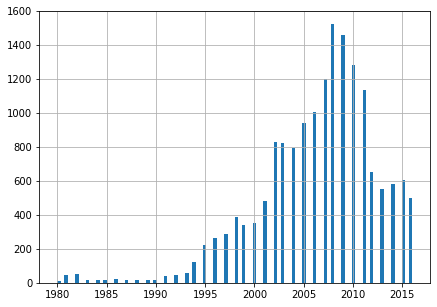

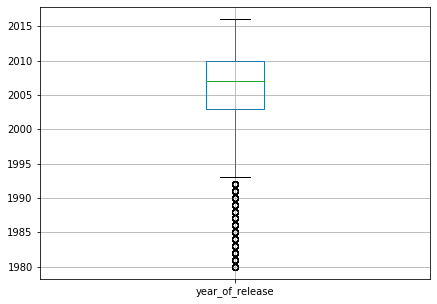

In [14]:
#построим гистограмму с данными сколько игр выходило в год
df['year_of_release'].hist(bins=100, figsize=(7,5))
plt.show()
#и диаграмму размаха
df.boxplot(column=['year_of_release'], figsize=(7,5))


Количество игр выпущенных до 1994 года минимально, что логично, т.к. игровая индустрия только зарождалась, эти данные в дальнейшем можно отбросить, т.к. статистической значимости они не несут
С 1994 года количество выходящих игр увеличилось в несколько раз, что, скорее всего обусловлено выходом playstation 1. Следующий скачок роста произошел в 2001-2002 годах, когда сменилось очередное поколение консолей. 
В третий раз количество релизов возросло на стыке поколений в 2006-2007 годах.
Последнея смена поколений, и на текущий момент актуальная, произошла в 2012-2013 годах. Текущее поколение консолей отличается от предыдущих снизившимся количеством релизов. Что скорее всего обусловлено возросшей стоимостью производства каждой отдельной игры, что влечёт за собой большие риски, и меньшее количество релизов. Так же вызросла популярность мобильных игр на IOS и ANDROID, что негативно сказалось на продажах и соответсвенно и количестве вышедших игр на карманных консолях.

#### Посмотрите, как менялись продажи по платформам.
Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

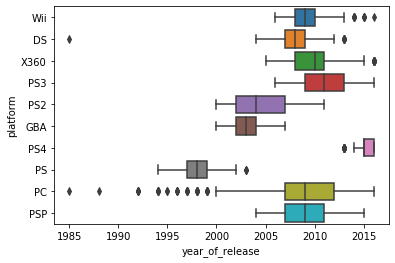

In [15]:
#возьмём топ 10 платформ по продажам
top10_platforms = list(df.groupby('platform')['all_sales'].sum().sort_values(ascending=False).head(10).index)
sb.boxplot(y="platform", x="year_of_release", data=df[df['platform'].isin(top10_platforms)])
plt.show()

Исходя из полученных данных, можно сделать вывод, что средний срок жизни игровой консоли составляет 10 лет. А пик продаж происходит со 2-3 года до 6-7 с момента выхода.

#### Возьмите данные за соответствующий актуальный период.

Исходя из изученных данных, актуальным периодом можно считать игры выпущенные с 2012 по 2016 год. 
т.к. c 2013 были выпущены консоли последнего (актуального) поколения. Т.к. данные за 2016 год не полные их учитывать не будем

In [16]:
#датафрейм с данными актуального опериода
df_actual = df.query('(year_of_release > 2011) & (year_of_release != 2016)').reset_index() 

#### Какие платформы лидируют по продажам, растут или падают?

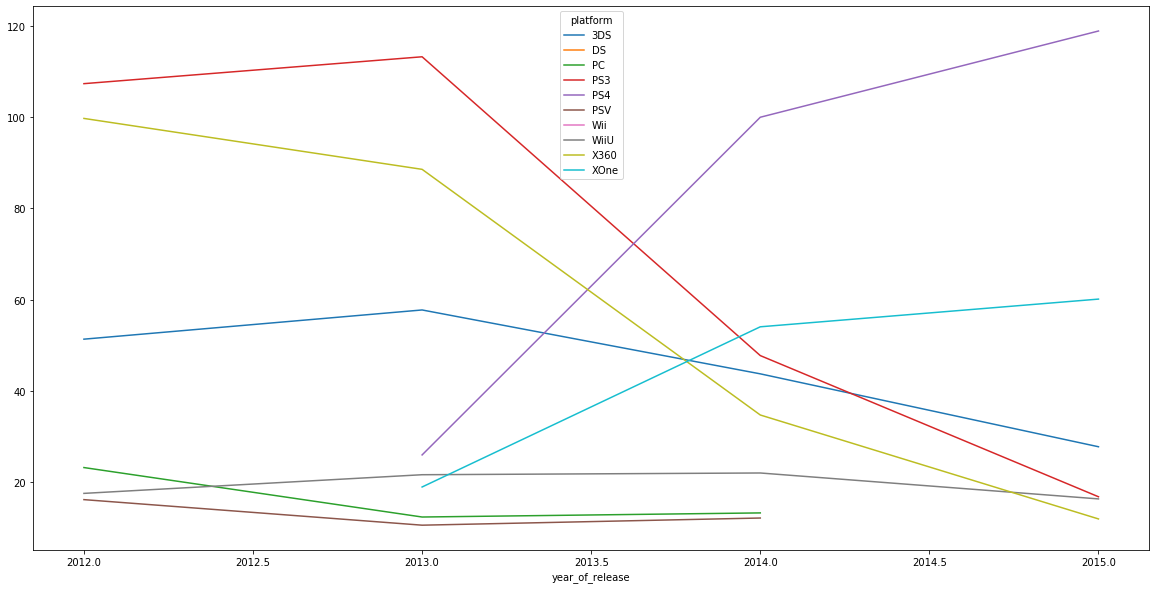

In [17]:
#сделаем df с актуальными, разбив продажи по каждой платформы по годам.
df_actual_byyear = df_actual.groupby(['platform','year_of_release'])['all_sales'].sum().reset_index()
#визуализируем продажи по каждой платформе в зависимости от года
df_actual_byyear.query('all_sales > 10').pivot_table(
    index='year_of_release',columns='platform', values='all_sales').plot(figsize=(20,10))

Из графика видно, что на текущее время потенциально выгодными являются 2 платформы: PS4 и XOne. Прибыль с платформ PS3 и X360 c 2013 года сильно снижается, т.к. жизненный цикл этих консолей подошёл к концу. Все остальные платформы показывают стабильный, но низкий результат по продажам.

#### Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. 

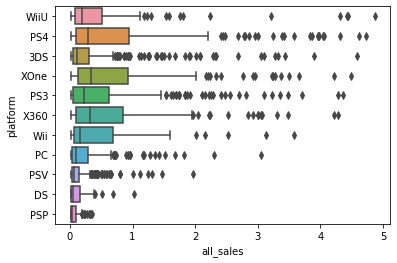

In [18]:
#для лучшей визуализации диаграммы размаха, срежем выбросы данных
boxplot = df_actual.query('all_sales < 5')
sb.boxplot(y="platform", x="all_sales", data=boxplot)

Исходя из диаграммы размаха по глобальным продажам игр за выбранный период, средние продажиу "топ" платформ примерно одинаковые. У непопулярных платформ продажи значительно ниже как в среднем так и в общем. Посмотрим разбивку по платформам в абсолютных продажах.

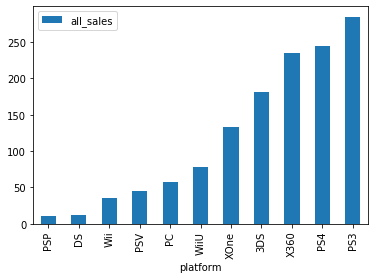

In [19]:
df_actual_byyear.groupby('platform')['all_sales'].sum().sort_values().reset_index().plot.bar(x='platform', y='all_sales')

Тут данные так же подтверждаются, что есть популярные платформы которые приносят большинство прибыли (3DS, XOne, X360, PS3, PS4) и остальные. Причём явным лидером по прибыли является платформа PS4, а учитывая динамику продаж, и спад в продажах платформ предыдущего поколения, можно сделать вывод, что платформа PS4 будет наиболее прибыльной в 2017 году.

#### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 

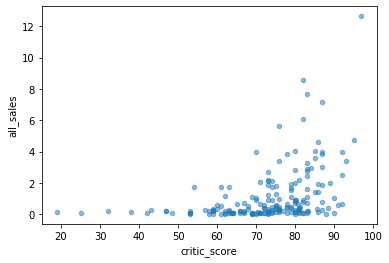

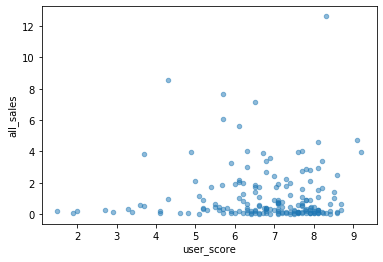

In [20]:
#удалим строки с пропусками в оценках критиков и пользователей
df_actual_filt = df_actual.dropna(axis='index', how='any', subset=['user_score','critic_score'])
#построим диаграммы рассеяния для платформы ps4, по критикам и пользователям
ps4 = df_actual_filt.query('platform == "PS4"')
ps4.plot(x='critic_score', y='all_sales', kind='scatter', alpha=0.5)
ps4.plot(x='user_score', y='all_sales', kind='scatter', alpha=0.5)


Наиболее прибыльные проекты, как правило получают больший рейтинг и оценку как от пользователей так и от критиков

In [21]:
#посмотрим на коэффициент корелляции
print('Корреляция с пользователями', ps4['user_score'].corr(ps4['all_sales']))
print('Корелляция с критиками', ps4['critic_score'].corr(ps4['all_sales']))

Корреляция с пользователями 0.016221444474130292
Корелляция с критиками 0.4043615787317975


Как видно из коэффициентов корелляции, связь между оценками пользователей и продажами отсутсвует в выбранной платформе.
Связь между оценками критиков и продажами есть, но достаточно слабая. 

#### Соотнесите выводы с продажами игр на других платформах.

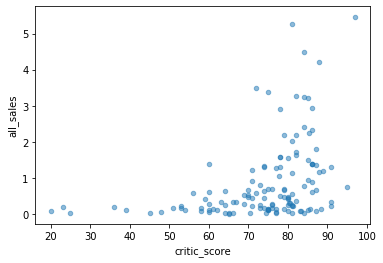

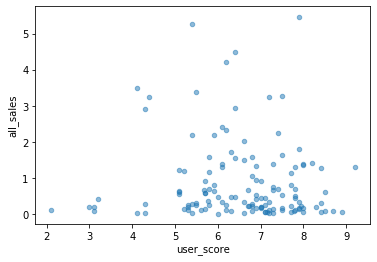

In [22]:
#построим диаграммы рассеяния для двух других популярных платформ (XONE и PS3)
xone = df_actual_filt.query('platform == "XOne"')
xone.plot(x='critic_score', y='all_sales', kind='scatter', alpha=0.5)
xone.plot(x='user_score', y='all_sales', kind='scatter', alpha=0.5)

In [23]:
print('Корреляция с пользователями', xone['user_score'].corr(xone['all_sales']))
print('Корелляция с критиками', xone['critic_score'].corr(xone['all_sales']))

Корреляция с пользователями -0.06377871864175368
Корелляция с критиками 0.3830106072475635


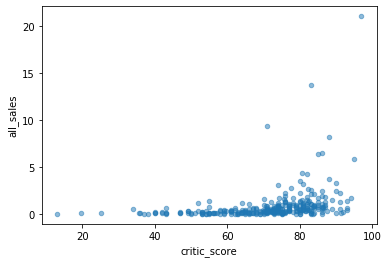

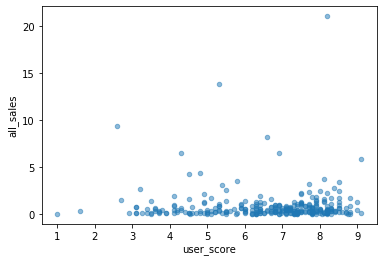

In [24]:
ps3 = df_actual_filt.query('platform == "PS3"')
ps3.plot(x='critic_score', y='all_sales', kind='scatter', alpha=0.5)
ps3.plot(x='user_score', y='all_sales', kind='scatter', alpha=0.5)

In [25]:
print('Корреляция с пользователями', ps3['user_score'].corr(ps3['all_sales']))
print('Корелляция с критиками', ps3['critic_score'].corr(ps3['all_sales']))

Корреляция с пользователями -0.008298980166261858
Корелляция с критиками 0.31667780360796854


Из полученных данных, можно сделать вывод, что влияние на оценки пользователей и критиков примерно одинаковое, в не зависимости от платформы.

#### Посмотрите на общее распределение игр по жанрам.

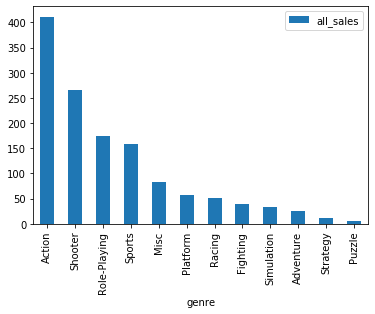

In [26]:
#сгруппируем по жанрам и сделаем гистограмму
df_actual.groupby('genre')['all_sales'].sum().sort_values(ascending=False).reset_index().plot.bar(x='genre', y='all_sales')

Самыми прибыльными жанрами являются "Action" и "Shooter", меньший доход приносят жанры "Role-Playing" и "Sports", у всех остальных жанров прибыль существенно меньше, но стоит учитывать, что игры в жанрах "Action" и "Shooter" обходятся существенно дороже в производстве.

## Портрет пользователя каждого региона


### Определите для пользователя каждого региона (NA, EU, JP)


#### Самые популярные платформы (топ-5). Опишите различия в долях продаж.

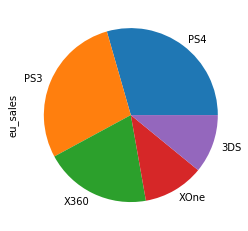

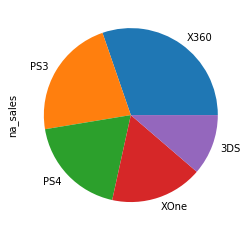

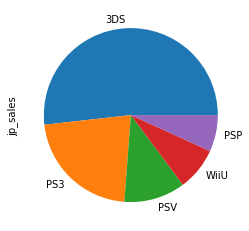

In [27]:
#построим круговые диаграммы с долями продаж по платформам в актуальном периоде в 3-ех основных регионах
df_actual.groupby('platform')['eu_sales'].sum().sort_values(ascending = False).head(5).plot(kind='pie',subplots=True)
plt.show()
df_actual.groupby('platform')['na_sales'].sum().sort_values(ascending = False).head(5).plot(kind='pie',subplots=True)
plt.show()
df_actual.groupby('platform')['jp_sales'].sum().sort_values(ascending = False).head(5).plot(kind='pie',subplots=True)
plt.show()

Лидерами по продажам в Европе, с общей долей более 60% являются платформы PS3 и пришедшая ей на смену PS4. 3 и 4 место делят платформы X360 и XOne, на последнем месте по популярности в топе карманная консоль 3DS

В Северной Америке, ситуация противоположная Европейской, лидерами являются платформы X360 и XOne, 3 и 4 место PS3 и PS4 соответсвтенно, карманная 3DS так же заняла 5 позицию.

Японский рынок платформ по распределению долей и координально отличается от европейского и американского рынков.Чётко видно доминирование карманных консолей в общей доле продаж. Здесь в большей степени лидирует, с долей продаж более 50% карманная платформа 3DS, так же пользуются популярностью PSV и PSP. Примерно 30% заняли домашние платформы PS3 и WiiU. Так же отличительной особенностью Японского рынка, является тот факт, что в лидерах продаж нет платформ последнего поколения XOne и PS4.

#### Самые популярные жанры (топ-5). Поясните разницу.

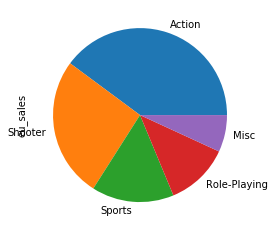

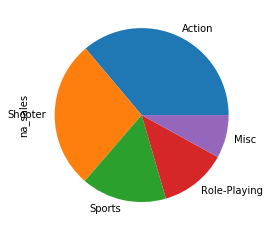

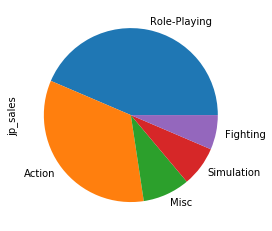

In [28]:
df_actual.groupby('genre')['eu_sales'].sum().sort_values(ascending = False).head(5).plot(kind='pie',subplots=True)
plt.show()
df_actual.groupby('genre')['na_sales'].sum().sort_values(ascending = False).head(5).plot(kind='pie',subplots=True)
plt.show()
df_actual.groupby('genre')['jp_sales'].sum().sort_values(ascending = False).head(5).plot(kind='pie',subplots=True)
plt.show()

Изучая популярность жанров. Видно, что в Европе и Северной Америке предпочтения пользователей идентичны, самые популярные жанры это Action и Shooter, так же весьма популярны жанры Sports, Misc и Role-Playing.

Предпочтения пользователей из Японии коардинально отличаются. Тут наибольшей популярностью пользуются игры жанра Role-Playing и Action. Занимая более 75% от общей доли продаж. Оставшие 25% делят жанры Misc, Simulation и Fighting. Популярные в Европе и Северной Америке жанры Sports и Shooter вообще не вошли в топ 5 предпочтений Японских пользователей.

####  Влияет ли рейтинг ESRB на продажи в отдельном регионе?

«E» (0+) — «Для всех»
«E10+» (10+) — «Для всех от 10 лет и старше»
«T» (13+) — «Подросткам
«M» (17+) — «Для взрослых»


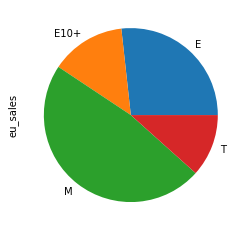

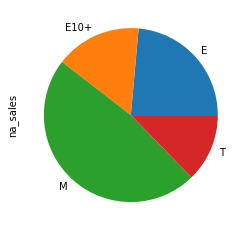

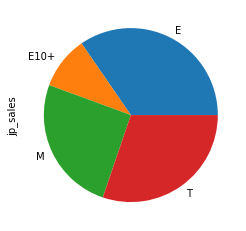

In [29]:
print('«E» (0+) — «Для всех»')
print('«E10+» (10+) — «Для всех от 10 лет и старше»')
print('«T» (13+) — «Подросткам')
print('«M» (17+) — «Для взрослых»')
df_actual.groupby('rating')['eu_sales'].sum().plot(kind='pie',subplots=True)
plt.show()
df_actual.groupby('rating')['na_sales'].sum().plot(kind='pie',subplots=True)
plt.show()
df_actual.groupby('rating')['jp_sales'].sum().plot(kind='pie',subplots=True)
plt.show()

Если в Европе и Северной Америке наибольшие продажи (49%) занимаю игры с рейтингом M(17+), то в Японии такие игры занимают долю менее четверти от всех продаж, а самым популярным рейтингом является E(0+).

Составляя портрет пользователей из разных регионов, можно сделать вывод что пользователи из Европы и Северной Америки имеют одинаковые предпочтения в играх, но предпочитают разные домашние консоли. А Японский рынок, представляет собой противоположность, в которой по продажам лидируют "карманные" консоли, игры отличных жанров и лучше всего продаются игры с самым "мягким" возрастным рейтингом.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

#### проверим гипотезу о равенстве средних двух генеральных совокупностей
- нулевая гипотеза: среднии пользовательские рейтинги одинаковые
- альтернативная гипотеза: среднии пользовательските рейтинги разные

In [30]:
#критический уровень статистической значимости
alpha = .05

#срезы XOne и PC
xone = df_actual.query('platform == "XOne"').dropna()
pc = df_actual.query('platform == "PC"').dropna()

#тест 
result = st.ttest_ind(
    xone['user_score'], 
    pc['user_score'])

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 0.7359660653032845
Не получилось отвергнуть нулевую гипотезу


- Исходя из полученных данных, можно предположить, что средние пользовательские рейтинги независимо от платформы XOne или PC схожие.

### Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.

#### Проверим гипотезу о равенстве средних двух генеральных совокупностей
- нулевая гипотеза: среднии пользовательские рейтинги одинаковые
- альтернативная гипотеза: среднии пользовательските рейтинги разные


In [31]:
#критический уровень статистической значимости
alpha = .05

#срезы XOne и PC
action = df_actual.query('genre == "Action"').dropna()
sports = df_actual.query('genre == "Sports"').dropna()

#тест 
result = st.ttest_ind(
    action['user_score'], 
    sports['user_score'])

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 2.0876124517173207e-24
Отвергаем нулевую гипотезу


- Исходя из полученных данных, можно предположить, что средние пользовательские рейтинги в жанрах Action и Sports различаются.

## Общий вывод 

### Проанализировав и изучив данные по продажам игр на различных платформах, можно сделать следующие выводы:

- Количество выпускаемых игр ежегодно росло, но с 2012 года резко уменьшилось. Скорее всего это связано с тем, что игры стали стоить дороже в производстве, что увеличивает риск банкротства издателя в случае нескольких провалов в продажах. А так же с тем, что уменьшилось количество релизов на "карманных" консолях, т.к. их место заняли устроиства на android и ios.

- Началом актуального периода (текущего поколения платформ) можно считать 2012 год. На конец 2015 года самыми перспиктивными являются платформы PS4 и XOne. 

- Отзывы пользователей не влияют на продажи игр. Небольшое влияние на продажи несут отзывы критиков. 

- Самыми прибыльными жанрами являются "Action" и "Shooter", меньший доход приносят жанры "Role-Playing" и "Sports", у всех остальных жанров прибыль существенно меньше.

- Если разделить пользователей по регионам, то можно заметить, что предпочтения игроков из Северной Америки и Европы весьма схожи, при этом предопчтения пользователей из Японии коардинально отличаются.

- Средние пользовательские рейтинги, схожи на разных платформах, но различаются в зависимости от жанра.